In [1]:
!pip install git+https://github.com/PLanza/johnsons-clrs-gnn.git@impl4

  Cloning https://github.com/PLanza/johnsons-clrs-gnn.git (to revision impl4) to /tmp/pip-req-build-ful6ne82
  Running command git clone --filter=blob:none --quiet https://github.com/PLanza/johnsons-clrs-gnn.git /tmp/pip-req-build-ful6ne82
  Running command git checkout -b impl4 --track origin/impl4
  Switched to a new branch 'impl4'
  Branch 'impl4' set up to track remote branch 'impl4' from 'origin'.
  Resolved https://github.com/PLanza/johnsons-clrs-gnn.git to commit 595cbe074a6837bc0df2bc24e0e824a0d320165c
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 371.7/371.7 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 55.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 13.8 MB/s eta 0:00:00
  Created wheel for dm-clrs: filename=dm_clrs-1.0.0-py3-none-any.whl size=113087 sha256=f0342eeb2147b3c193f8cfcf479f23ecb491e352453904fba9140b70eb7dfed6
  Stored in directory: /tmp/pip-ephem-wheel-ca

In [2]:
from clrs.examples import run
import numpy as np
import jax
import clrs
import functools
from absl import logging
import random
import sys

seed = random.randint(0,1000)

run.FLAGS([sys.argv])
run.FLAGS.seed = seed

train_lengths = [int(x) for x in run.FLAGS.train_lengths]

rng = np.random.RandomState(run.FLAGS.seed)

In [3]:
import pickle
def load_model(file_path, algorithm):

  run.FLAGS.algorithms = [algorithm]

  FLAGS = run.FLAGS
  encode_hints = True
  decode_hints = True
  print(FLAGS.algorithms)

  processor_factory = clrs.get_processor_factory(
      FLAGS.processor_type,
      use_ln=FLAGS.use_ln,
      nb_triplet_fts=FLAGS.nb_triplet_fts,
      nb_heads=FLAGS.nb_heads
  )
  model_params = dict(
      processor_factory=processor_factory,
      hidden_dim=FLAGS.hidden_size,
      encode_hints=encode_hints,
      decode_hints=decode_hints,
      encoder_init=FLAGS.encoder_init,
      use_lstm=FLAGS.use_lstm,
      learning_rate=FLAGS.learning_rate,
      grad_clip_max_norm=FLAGS.grad_clip_max_norm,
      checkpoint_path=FLAGS.checkpoint_path,
      freeze_processor=FLAGS.freeze_processor,
      dropout_prob=FLAGS.dropout_prob,
      hint_teacher_forcing=FLAGS.hint_teacher_forcing,
      hint_repred_mode=FLAGS.hint_repred_mode,
      nb_msg_passing_steps=FLAGS.nb_msg_passing_steps,
      )

  (train_samplers,
    val_samplers, val_sample_counts,
    test_samplers, test_sample_counts,
    spec_list) = run.create_samplers(rng, train_lengths)

  eval_model = clrs.models.BaselineModel(
      spec=spec_list,
      dummy_trajectory=[next(train_samplers[0])],
      **model_params
  )

  with open(file_path, 'rb') as f:
    restored_state = pickle.load(f)
    eval_model.params = restored_state['params']
    eval_model.opt_state = restored_state['opt_state']

  return eval_model

In [4]:
rng = np.random.RandomState(run.FLAGS.seed)

def get_test_sampler(algorithm):
  common_sampler_args = dict(
    algorithm=algorithm,
    rng=rng,
    enforce_pred_as_input=True,
    enforce_permutations=True,
    chunk_length=16,
    )
  test_args = dict(sizes=[64],
                   split='test',
                   batch_size=32,
                   multiplier=2,
                   randomize_pos=False,
                   chunked=False,
                   sampler_kwargs={},
                   **common_sampler_args)

  return run.make_multi_sampler(**test_args)

In [5]:
def eval_hints(model, algorithm):
  sampler, num_samples, spec = get_test_sampler(algorithm)

  rng = np.random.RandomState(run.FLAGS.seed)
  rng_key = jax.random.PRNGKey(rng.randint(2**32))

  import pickle
  from clrs._src import algorithms

  predict_fn = functools.partial(model.predict, algorithm_index=0)

  processed_samples = 0
  outputs = []
  preds = []
  hints = []
  hint_preds = []
  lengths = []

  while processed_samples < num_samples:
    feedback = next(sampler)
    batch_size = feedback.outputs[0].data.shape[0]
    outputs.append(feedback.outputs)
    hints.append(feedback.features.hints)
    lengths.append(feedback.features.lengths)
    new_rng_key, rng_key = jax.random.split(rng_key)
    cur_preds, cur_hints = predict_fn(new_rng_key, feedback.features, return_hints=True)
    preds.append(cur_preds)
    hint_preds.append(cur_hints)
    processed_samples += batch_size

  hints = run._concat(hints, axis=1)
  hint_preds = run._concat(hint_preds, axis=0)
  lengths = run._concat(lengths, axis=0)

  hint_preds = [clrs._src.decoders.postprocess(clrs.SPECS[algorithm],
                                              hs,
                                              sinkhorn_temperature=0.1,
                                              sinkhorn_steps=25, hard=True)
  for hs in hint_preds]

  outputs = run._concat(outputs, axis=0)
  preds = run._concat(preds, axis=0)

  return (clrs.evaluate(outputs, preds), clrs.evaluate_hints(hints, np.array(lengths), hint_preds))

In [7]:
model = load_model('./best4_1.pkl', 'johnsons')

['johnsons']


In [8]:
outs_eval, hints_eval = eval_hints(model, 'johnsons')

In [9]:
outs_eval

{'Pi': 0.8896102905273438, 'score': 0.8896102905273438}

In [10]:
from collections import OrderedDict

scalar_features = ['d', 'A_rw', 'D']
to_draw = {}

for k in hints_eval.keys():
  suffix = k.find('_along_time')
  if suffix != -1:
    to_draw[k[:suffix]] = hints_eval[k]

for feat in scalar_features:
  to_draw.pop(feat)

to_draw = OrderedDict(sorted(to_draw.items()))


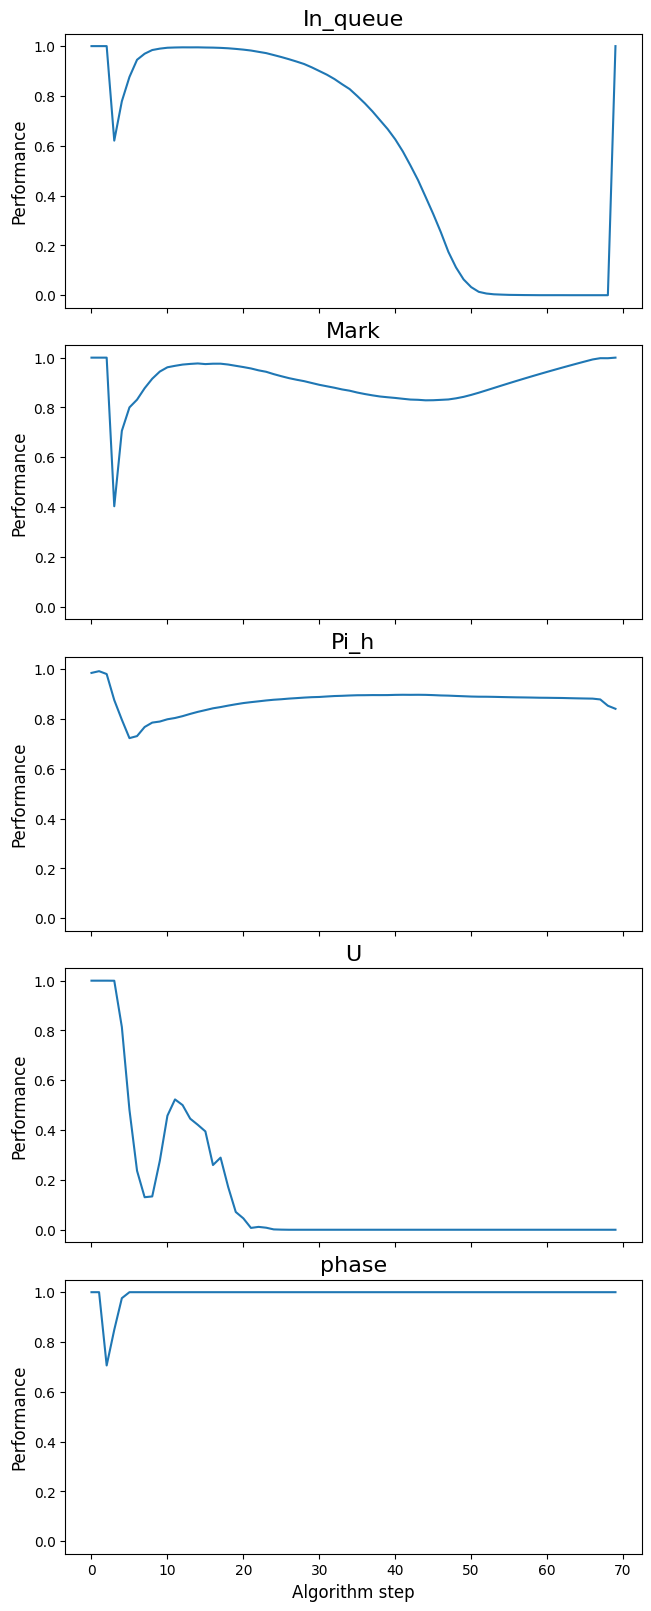

In [11]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(len(to_draw), 1, sharex=True, constrained_layout=True)
fig.set_figheight(16)

for (i, k) in enumerate(to_draw):
  hint = k
  y = to_draw[k]
  axs[i].plot(range(len(y)), y)
  axs[i].set_title(hint, fontsize=16)
  axs[i].set_ylabel('Performance', fontsize=12)
  axs[i].set_ylim([-0.05,1.05])
  if i == len(to_draw) - 1:
    axs[i].set_xlabel('Algorithm step', fontsize=12)

In [12]:
import pickle
with open('hints.pickle', 'wb') as hints_file:
  pickle.dump(hints_eval, hints_file, protocol=pickle.HIGHEST_PROTOCOL)